In [1]:
from pyspark.sql import SparkSession
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.functions import col

# %%
spark = SparkSession.builder \
    .appName("SECOP_RegresionLineal") \
    .master("spark://spark-master:7077") \
    .getOrCreate()

print(f"Spark Version: {spark.version}")
print(f"Spark Master: {spark.sparkContext.master}")

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
26/02/14 03:20:35 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Spark Version: 3.5.0
Spark Master: spark://spark-master:7077


26/02/14 03:20:53 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors


In [2]:
# Cargar datos
df = spark.read.parquet("/opt/spark-data/raw/secop_ml_ready.parquet")

# Renombrar columnas para consistencia
df = df.withColumnRenamed("valor_del_contrato_log", "label") \
       .withColumnRenamed("features_pca", "features")

# Filtrar valores nulos
df = df.filter(col("label").isNotNull())
print(f"Registros: {df.count():,}")
print(f"Columnas: {len(df.columns)}")

Registros: 100,000
Columnas: 2


### **Definir estrategia de train/test split**

Estrategia definida: 70% entrenamiento, 30% prueba

In [3]:
train_ratio = 0.7
test_ratio = 0.3

train, test = df.randomSplit([train_ratio,test_ratio],
                             seed = 45 #Reproducibilidad
                            )

print("\n=== TRAIN / TEST SPLIT ===")
print(f"Train: {train.count():,} registros ({train_ratio*100:.0f}%)")
print(f"Test:  {test.count():,} registros ({test_ratio*100:.0f}%)")


=== TRAIN / TEST SPLIT ===


Train: 70,126 registros (70%)
Test:  29,874 registros (30%)


### *Configurar modelo de LinearRegression**

In [4]:
lr = LinearRegression(featuresCol="features",
                     labelCol="label",
                     maxIter=100, # Iteraciones suficientes para converger
                     regParam=0.0,  # Sin regularización (baseline)
                     elasticNetParam=0.0) # No aplica sin regularización

print("✓ Modelo de Regresión Lineal configurado")
print(f"  featuresCol: {lr.getFeaturesCol()}")
print(f"  labelCol:    {lr.getLabelCol()}")
print(f"  maxIter:     {lr.getMaxIter()}")
print(f"  regParam:    {lr.getRegParam()}")
print(f"  elasticNet:  {lr.getElasticNetParam()}")

✓ Modelo de Regresión Lineal configurado
  featuresCol: features
  labelCol:    label
  maxIter:     100
  regParam:    0.0
  elasticNet:  0.0


## **Interpretar R² del modelo**

In [5]:
print("Entrenando modelo de regresión lineal...")
lr_model = lr.fit(train)

print("✓ Modelo entrenado")
print(f"Solver utilizado: {lr_model.getSolver()}")


Entrenando modelo de regresión lineal...


26/02/14 03:21:49 WARN Instrumentation: [c3752639] regParam is zero, which might cause numerical instability and overfitting.
26/02/14 03:21:50 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
26/02/14 03:21:50 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.VectorBLAS
26/02/14 03:21:50 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.lapack.JNILAPACK


✓ Modelo entrenado
Solver utilizado: auto


In [7]:
# %%
r2_train = lr_model.summary.r2
rmse_train = lr_model.summary.rootMeanSquaredError

print("\n=== MÉTRICAS EN TRAIN ===")
print(f"R² (train):  {r2_train:.4f}")
print(f"RMSE (train): {rmse_train:,.2f}")



=== MÉTRICAS EN TRAIN ===
R² (train):  0.7417
RMSE (train): 0.94


### **Analizar calidad de predicciones y errores**

In [8]:
predictions= lr_model.transform(test)
print("\n=== EJEMPLO DE PREDICCIONES ===")
predictions.select("label", "prediction").show(10, truncate=False)


=== EJEMPLO DE PREDICCIONES ===
+------------------+------------------+
|label             |prediction        |
+------------------+------------------+
|18.504252340842562|18.152401904771786|
|18.06257622151019 |17.939663099239688|
|17.716362438072828|17.77290491711623 |
|17.716362438072828|17.77290491711623 |
|17.114319336790984|17.48292335678388 |
|17.047470175500084|17.450724625402735|
|16.819211050770615|17.340780774193057|
|16.770420889081343|17.31728038495946 |
|16.60386164879278 |17.23705505178346 |
|24.493441458355807|20.855813027382347|
+------------------+------------------+
only showing top 10 rows



In [11]:
from pyspark.sql.functions import abs as spark_abs

predictions_with_error = predictions.withColumn(
    "absolute_error",
    spark_abs(col("prediction") - col("label"))
)

print("\n=== PREDICCIONES CON ERROR ABSOLUTO ===")
predictions_with_error.select(
    "label", "prediction", "absolute_error"
).show(10, truncate=False)

print("\n=== TOP 10 PEORES PREDICCIONES (MAYOR ERROR) ===")

predictions_with_error \
    .orderBy(col("absolute_error").desc()) \
    .select("label", "prediction", "absolute_error") \
    .show(10, truncate=False)

# %%
print("\n=== TOP 10 PEORES PREDICCIONES (MAYOR ERROR) ===")

predictions_with_error \
    .orderBy(col("absolute_error").desc()) \
    .select("label", "prediction", "absolute_error") \
    .show(10, truncate=False)



=== PREDICCIONES CON ERROR ABSOLUTO ===
+------------------+------------------+-------------------+
|label             |prediction        |absolute_error     |
+------------------+------------------+-------------------+
|18.504252340842562|18.152401904771786|0.3518504360707766 |
|18.06257622151019 |17.939663099239688|0.12291312227050355|
|17.716362438072828|17.77290491711623 |0.05654247904340082|
|17.716362438072828|17.77290491711623 |0.05654247904340082|
|17.114319336790984|17.48292335678388 |0.36860401999289394|
|17.047470175500084|17.450724625402735|0.4032544499026507 |
|16.819211050770615|17.340780774193057|0.5215697234224415 |
|16.770420889081343|17.31728038495946 |0.5468594958781168 |
|16.60386164879278 |17.23705505178346 |0.6331934029906812 |
|24.493441458355807|20.855813027382347|3.637628430973461  |
+------------------+------------------+-------------------+
only showing top 10 rows


=== TOP 10 PEORES PREDICCIONES (MAYOR ERROR) ===
+------------------+------------------+----

In [13]:
# %%
predictions_with_error = predictions_with_error.withColumn(
    "error_porcentual",
    (col("absolute_error") / col("label")) * 100
)

print("\n=== EJEMPLO DE ERROR PORCENTUAL ===")
predictions_with_error.select(
    "label", "prediction", "error_porcentual"
).show(10, truncate=False)



=== EJEMPLO DE ERROR PORCENTUAL ===
+------------------+------------------+------------------+
|label             |prediction        |error_porcentual  |
+------------------+------------------+------------------+
|18.504252340842562|18.152401904771786|1.9014571871902803|
|18.06257622151019 |17.939663099239688|0.6804850025996287|
|17.716362438072828|17.77290491711623 |0.3191539981248626|
|17.716362438072828|17.77290491711623 |0.3191539981248626|
|17.114319336790984|17.48292335678388 |2.1537755182614755|
|17.047470175500084|17.450724625402735|2.3654797207517118|
|16.819211050770615|17.340780774193057|3.1010356065336633|
|16.770420889081343|17.31728038495946 |3.2608573123776434|
|16.60386164879278 |17.23705505178346 |3.8135309507154256|
|24.493441458355807|20.855813027382347|14.851438648007967|
+------------------+------------------+------------------+
only showing top 10 rows



## **Comparar train vs test para detectar overfitting**

In [14]:
evaluator_rmse = RegressionEvaluator(labelCol="label",
                                    predictionCol="prediction",
                                    metricName="rmse")

evaluator_mae = RegressionEvaluator(labelCol="label",
                                    predictionCol="prediction",
                                    metricName="mae")

evaluator_r2 = RegressionEvaluator(labelCol="label",
                                    predictionCol="prediction",
                                    metricName="r2")

rmse = evaluator_rmse.evaluate(predictions)
mae = evaluator_mae.evaluate(predictions)
r2 = evaluator_r2.evaluate(predictions)

print("\n=== MÉTRICAS EN TEST ===")
print("rmse:", rmse)
print("mae:",mae)
print("r2:",r2)

print("="*60)

print("\n=== COMPARACIÓN TRAIN VS TEST ===")
print(f"R² Train: {lr_model.summary.r2:.4f}")
print(f"R² Test:  {r2:.4f}")
print(f"Diferencia absoluta: {abs(lr_model.summary.r2 - r2):.4f}")


=== MÉTRICAS EN TEST ===
rmse: 0.9551096306564667
mae: 0.4623811369571218
r2: 0.7440137919461022

=== COMPARACIÓN TRAIN VS TEST ===
R² Train: 0.7417
R² Test:  0.7440
Diferencia absoluta: 0.0023


### **Analizar coeficientes del modelo**

In [15]:
coefficients = lr_model.coefficients
intercept = lr_model.intercept

print(f"Intercepto: {intercept:,.2f}")
print(f"Número de coeficientes: {len(coefficients)}")

Intercepto: 8.79
Número de coeficientes: 30


### **Analisis de distribucion de residuos**

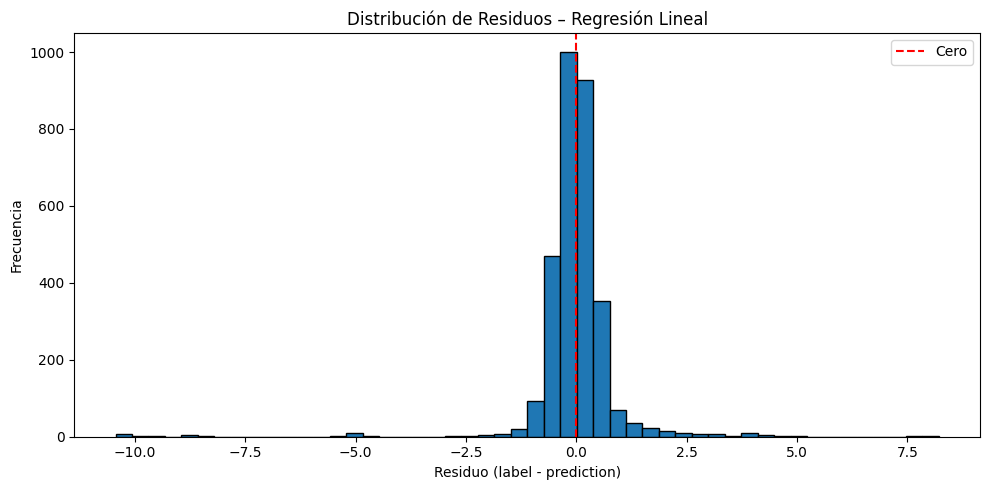

In [16]:
from pyspark.sql.functions import col
import pandas as pd
import matplotlib.pyplot as plt

# Calcular residuos
residuals_df = predictions.withColumn(
    "residual",
    col("label") - col("prediction")
)

# Tomar muestra para visualización
residuals_sample = residuals_df.select("residual") \
    .sample(0.1, seed=42) \
    .toPandas()

# Histograma de residuos
plt.figure(figsize=(10, 5))
plt.hist(residuals_sample["residual"], bins=50, edgecolor="black")
plt.axvline(0, color="red", linestyle="--", label="Cero")
plt.xlabel("Residuo (label - prediction)")
plt.ylabel("Frecuencia")
plt.title("Distribución de Residuos – Regresión Lineal")
plt.legend()
plt.tight_layout()

plt.show()


### **Feature importance aproximado**

In [17]:
import numpy as np

coef_array = np.array(lr_model.coefficients)
abs_coefs = np.abs(coef_array)

# Top 10 componentes más influyentes
top_idx = np.argsort(abs_coefs)[-10:]

print("\n=== TOP 10 COMPONENTES PCA MÁS IMPORTANTES ===")
for rank, idx in enumerate(reversed(top_idx), start=1):
    print(
        f"{rank}. PC{idx+1} | "
        f"Coeficiente: {coef_array[idx]:.6f} | "
        f"|Coef|: {abs_coefs[idx]:.6f}"
    )



=== TOP 10 COMPONENTES PCA MÁS IMPORTANTES ===
1. PC3 | Coeficiente: -1.225635 | |Coef|: 1.225635
2. PC4 | Coeficiente: 0.290171 | |Coef|: 0.290171
3. PC1 | Coeficiente: -0.118095 | |Coef|: 0.118095
4. PC8 | Coeficiente: 0.114240 | |Coef|: 0.114240
5. PC5 | Coeficiente: -0.087070 | |Coef|: 0.087070
6. PC6 | Coeficiente: 0.076073 | |Coef|: 0.076073
7. PC17 | Coeficiente: -0.056776 | |Coef|: 0.056776
8. PC21 | Coeficiente: -0.055518 | |Coef|: 0.055518
9. PC30 | Coeficiente: -0.054747 | |Coef|: 0.054747
10. PC28 | Coeficiente: 0.051529 | |Coef|: 0.051529


In [18]:
# Guardar modelo
model_path = "/opt/spark-data/raw/linear_regression_model"
lr_model.save(model_path)
print(f"\nModelo guardado en: {model_path}")

# %%
# Guardar predicciones
predictions_path = "/opt/spark-data/raw/predictions_lr.parquet"
predictions.write.mode("overwrite").parquet(predictions_path)
print(f"Predicciones guardadas en: {predictions_path}")

# %%
spark.stop()


Modelo guardado en: /opt/spark-data/raw/linear_regression_model


Predicciones guardadas en: /opt/spark-data/raw/predictions_lr.parquet
